In [1]:
# I wish to apply here ARIMA model and predictthe stock market trend
#--------------------------------------------------------------------
#autoregressive integrated moving average (ARIMA) model has been used very often for time series analysis
#The AR part of ARIMA indicates that the evolving variable of interest is regressed on its own lagged (i.e., prior) values.
#The MA part indicates that the regression error is actually a linear combination of error terms whose values occurred contemporaneously and at various times in the past.
#The I (for "integrated") indicates that the data values have been replaced with the difference between their values and the previous values (and this differencing process may have been performed more than once). 
#The purpose of each of these features is to make the model fit the data as well as possible.

In [2]:
# required Libraries
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

In [4]:
#Loading the dataset
data = pd.read_csv('dataset.csv')
print data.tail()
#checking the datatype
print '\n Data Types:'
print data.dtypes

             Date     Open     High      Low    Close       Volume
37585  2017-12-18  2685.92  2694.97  2685.92  2690.16  608455168.0
37586  2017-12-19  2692.71  2694.44  2680.74  2681.47  556473472.0
37587  2017-12-20  2688.18  2691.01  2676.11  2679.25  521377568.0
37588  2017-12-21  2683.02  2692.64  2682.40  2684.57  511474976.0
37589  2017-12-22  2684.22  2685.35  2678.13  2683.34          NaN

 Data Types:
Date       object
Open      float64
High      float64
Low       float64
Close     float64
Volume    float64
dtype: object


In [6]:
#Indexed_data
#date_parser: This specifies a function which converts an input string into datetime variable
#index_col: A key idea behind using Pandas for TS data is that the index has to be the variable depicting date-time information. 
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
data = pd.read_csv('dataset.csv', index_col='Date',date_parser=dateparse)
print data.tail()

               Open     High      Low    Close       Volume
Date                                                       
2017-12-18  2685.92  2694.97  2685.92  2690.16  608455168.0
2017-12-19  2692.71  2694.44  2680.74  2681.47  556473472.0
2017-12-20  2688.18  2691.01  2676.11  2679.25  521377568.0
2017-12-21  2683.02  2692.64  2682.40  2684.57  511474976.0
2017-12-22  2684.22  2685.35  2678.13  2683.34          NaN


In [7]:
# Checking the indexing
data.index

DatetimeIndex(['1789-05-01', '1789-06-01', '1789-07-01', '1789-08-01',
               '1789-09-01', '1789-10-01', '1789-11-01', '1789-12-01',
               '1790-01-01', '1790-02-01',
               ...
               '2017-12-11', '2017-12-12', '2017-12-13', '2017-12-14',
               '2017-12-15', '2017-12-18', '2017-12-19', '2017-12-20',
               '2017-12-21', '2017-12-22'],
              dtype='datetime64[ns]', name=u'Date', length=37590, freq=None)

In [8]:
# splitting the dataset using start date and end date index.
# I am interested in this section of data as the data dating earliear from 1980 is not relevant for today's stcok prediction
# I hope I have sufficient data for training and testing
TimeSeries_data = data['1980-01-01':'2017-11-01']

In [26]:
TimeSeries_data = TimeSeries_data['High']
TimeSeries_data.count()

9544

In [27]:
#What makes Time Series Special?
    #time dependent
    # seasonality trends, i.e. variations specific to a particular time frame.

In [28]:
#How to Check Stationarity of a Time Series?
        #if its statistical properties such as mean, variance remain constant over time

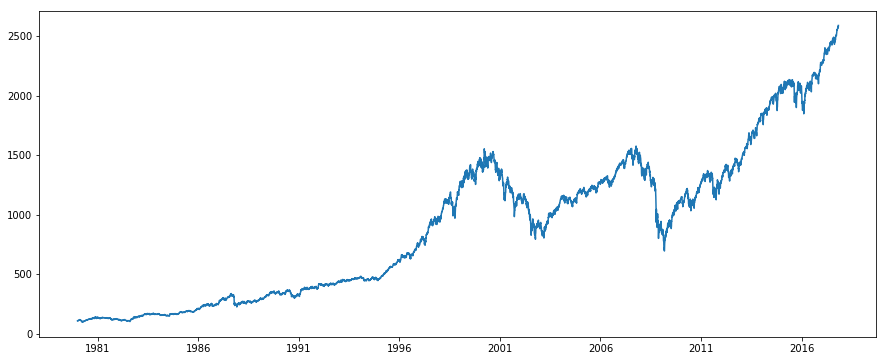

In [29]:
#plot the dataset 'High' Stock Market value for visual analysation
plt.plot(TimeSeries_data)

In [30]:
## 1.Plotting Rolling Statistics:
#    We can plot the moving average or moving variance and see if it varies with time.
#     By moving average/variance I mean that at any instant ‘t’, we’ll take the average/variance of the last year, i.e.
#     last 12 months. But again this is more of a visual technique.

## 2.Dickey-Fuller Test:
#    This is one of the statistical tests for checking stationarity. 
#    Here the null hypothesis is that the TimeSeries is non-stationary. 
#    The test results comprise of a Test Statistic and some Critical Values for difference confidence levels. 
#    If the ‘Test Statistic’ is less than the ‘Critical Value’, we can reject the null hypothesis and say that the series is stationary

In [31]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=365)
    rolstd = pd.rolling_std(timeseries, window=365)

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print 'Results of Dickey-Fuller Test:'
    #dftest = adfuller(timeseries.iloc[:,0].values, autolag='AIC')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print dfoutput

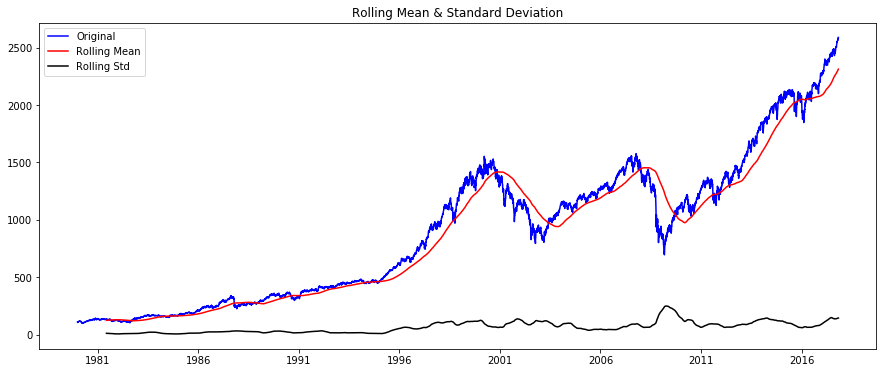

Results of Dickey-Fuller Test:
Test Statistic                    1.429210
p-value                           0.997243
#Lags Used                       36.000000
Number of Observations Used    9507.000000
Critical Value (5%)              -2.861844
Critical Value (1%)              -3.431038
Critical Value (10%)             -2.566932
dtype: float64


In [32]:
# Plotting the Rolling mean
# taking away future depreciation warning messages
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
test_stationarity(TimeSeries_data)

In [33]:
# Here the ‘Test Statistic’ is not less than the ‘Critical Value’(taking signed value), we can not reject the null hypothesis of Dickey-Fuller Test.
# hence, the Timeseries is non-stationary as per the null hypothesis.

In [34]:
#How to make a Time Series Stationary?
#-------------------------------------
#The underlying principle is to model or estimate the trend and seasonality in the series 
#and remove those from the series to get a stationary series.
    #1. Trend – varying mean over time. For eg, in this case we saw that on average, the number of passengers was growing over time.
    #2. Seasonality – variations at specific time-frames. eg people might have a tendency to buy cars in a particular month because of pay increment or festivals

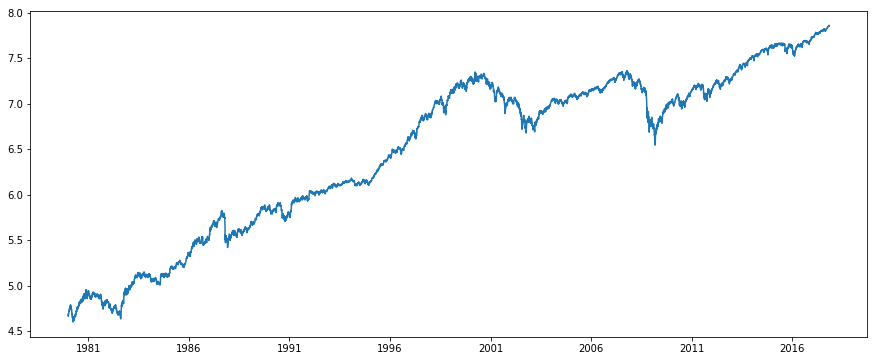

In [35]:
#Estimating & Eliminating Trend
# Using LOG Tranformation to remove Trend
TimeSeries_log = np.log(TimeSeries_data)
plt.plot(TimeSeries_log)

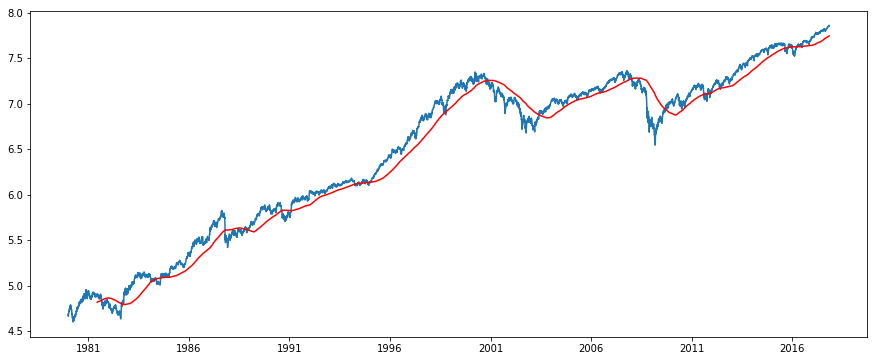

In [36]:
#Moving Average
    #In this approach, we take average of ‘k’ consecutive values depending on the frequency of time series. 
    #Here we can take the average over the past 1 year, i.e. last 365 values
moving_avg = pd.rolling_mean(TimeSeries_log,365)
plt.plot(TimeSeries_log)
plt.plot(moving_avg, color='red')

In [39]:
#The red line shows the rolling mean. Lets subtract this from the original series.
ts_log_moving_avg_diff = TimeSeries_log - moving_avg
ts_log_moving_avg_diff.tail(10)

Date
2017-10-19    0.110009
2017-10-20    0.114520
2017-10-23    0.115030
2017-10-24    0.112058
2017-10-25    0.109610
2017-10-26    0.108886
2017-10-27    0.114446
2017-10-30    0.112665
2017-10-31    0.111374
2017-11-01    0.114656
Name: High, dtype: float64

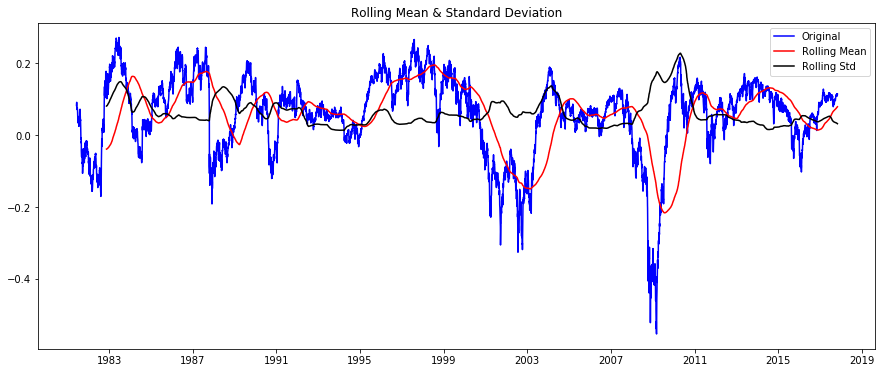

Results of Dickey-Fuller Test:
Test Statistic                   -4.144529
p-value                           0.000817
#Lags Used                       17.000000
Number of Observations Used    9162.000000
Critical Value (5%)              -2.861856
Critical Value (1%)              -3.431064
Critical Value (10%)             -2.566938
dtype: float64


In [40]:
# Droppping all Nan values
#and check the plots to test stationarity.
ts_log_moving_avg_diff.dropna(inplace=True)
test_stationarity(ts_log_moving_avg_diff)

In [41]:
#Test Statistic  is less than Critical values
#the test statistic is smaller than the 1% critical value,

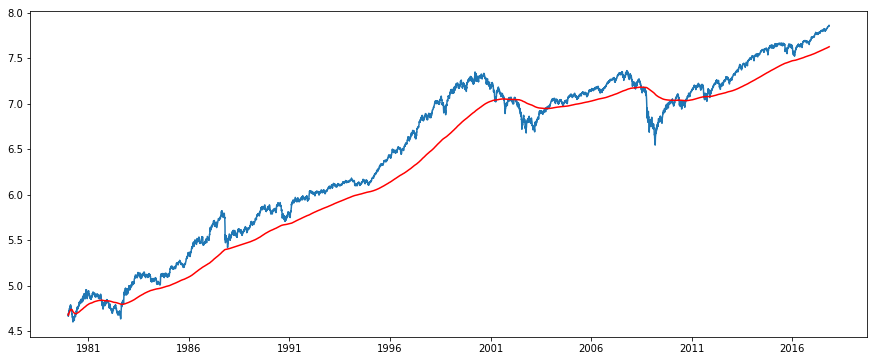

In [43]:
#e take a ‘weighted moving average’ where more recent values are given a higher weight.
#the parameter ‘halflife’ is used to define the amount of exponential decay.
expwighted_avg = pd.ewma(TimeSeries_log, halflife=365)
plt.plot(TimeSeries_log)
plt.plot(expwighted_avg, color='red')

In [44]:
#Eliminating Trend and Seasonality
# Differencing – taking the differece with a particular time lag
#Decomposition – modeling both trend and seasonality and removing them from the model.

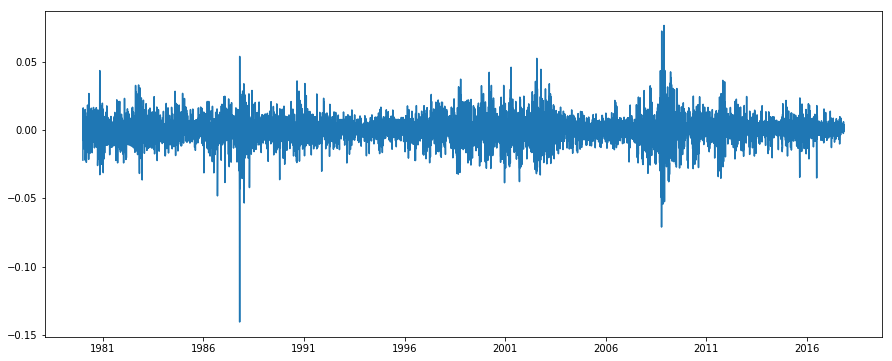

In [45]:
ts_log_diff = TimeSeries_log - TimeSeries_log.shift()
plt.plot(ts_log_diff)

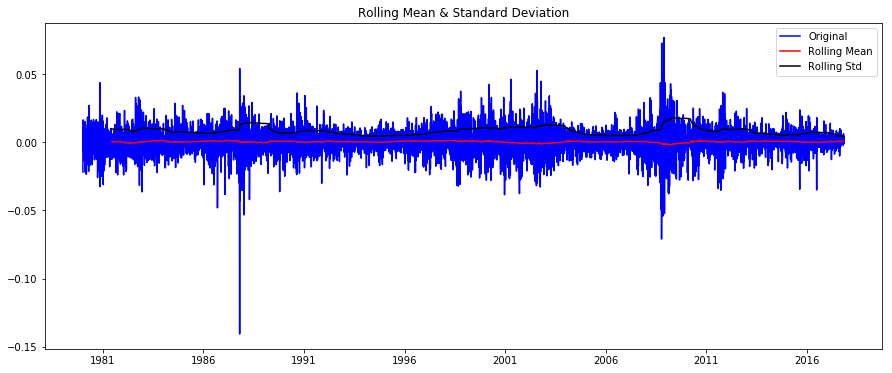

Results of Dickey-Fuller Test:
Test Statistic                  -38.065387
p-value                           0.000000
#Lags Used                        6.000000
Number of Observations Used    9536.000000
Critical Value (5%)              -2.861843
Critical Value (1%)              -3.431036
Critical Value (10%)             -2.566931
dtype: float64


In [46]:
#This appears to have reduced trend considerably. Lets verify using our plots:
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

In [47]:
#We can see that the mean and std variations have small variations with time.
#Also, the Dickey-Fuller test statistic is less than the 10% critical value, 
#thus the TS is stationary with 90% confidence.

In [49]:
###Forecasting a Time Series####
from statsmodels.tsa.arima_model import ARIMA

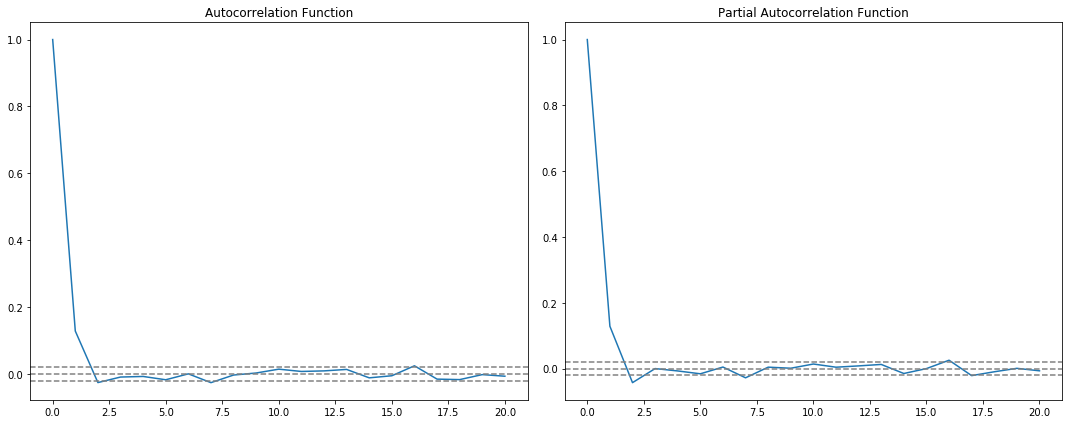

In [50]:
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf  

lag_acf = acf(ts_log_diff, nlags=20)
lag_pacf = pacf(ts_log_diff, nlags=20, method='ols')

#Plot ACF:    
plt.subplot(121)    
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

Text(0.5,1,u'RSS: 0.7311')

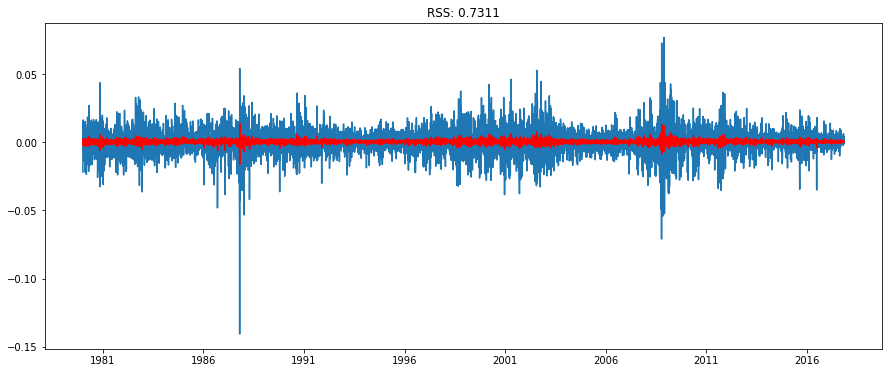

In [52]:

#AR model:
model = ARIMA(TimeSeries_log, order=(2, 1, 0))  
results_AR = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-ts_log_diff)**2))

Text(0.5,1,u'RSS: 0.7311')

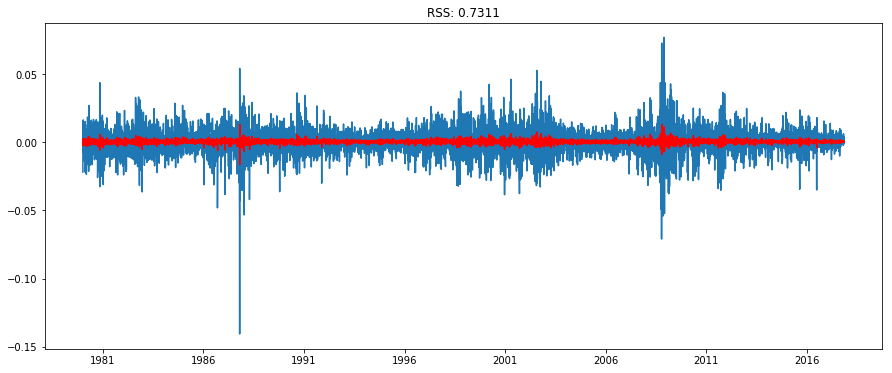

In [54]:
#MA Model
model = ARIMA(TimeSeries_log, order=(0, 1, 2))  
results_MA = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-ts_log_diff)**2))

C:\ProgramData\Anaconda2\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


Text(0.5,1,u'RSS: 0.7310')

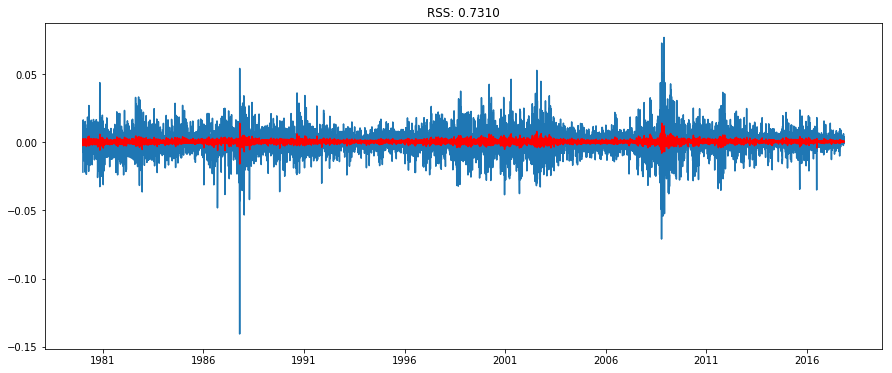

In [55]:
#ARIMA model
model = ARIMA(TimeSeries_log, order=(2, 1, 2))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_log_diff)**2))

In [57]:
#Convert to original scale
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print predictions_ARIMA_diff.tail()

Date
2017-10-26    0.000104
2017-10-27    0.000326
2017-10-30    0.001129
2017-10-31   -0.000108
2017-11-01    0.000265
dtype: float64


In [59]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print predictions_ARIMA_diff_cumsum.tail()

Date
2017-10-26    3.170055
2017-10-27    3.170382
2017-10-30    3.171510
2017-10-31    3.171402
2017-11-01    3.171667
dtype: float64


In [61]:
predictions_ARIMA_log = pd.Series(TimeSeries_log.ix[0], index=TimeSeries_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.tail()

Date
2017-10-26    7.856160
2017-10-27    7.856486
2017-10-30    7.857615
2017-10-31    7.857507
2017-11-01    7.857772
dtype: float64

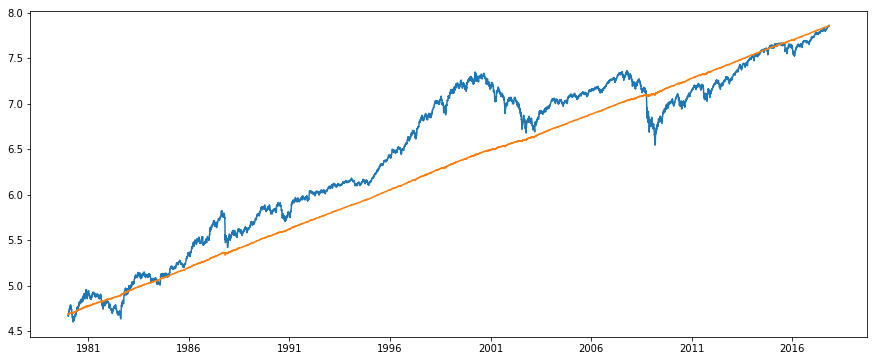

In [63]:
plt.plot(TimeSeries_log)
plt.plot(predictions_ARIMA_log)

Text(0.5,1,u'RMSE: 282.1114')

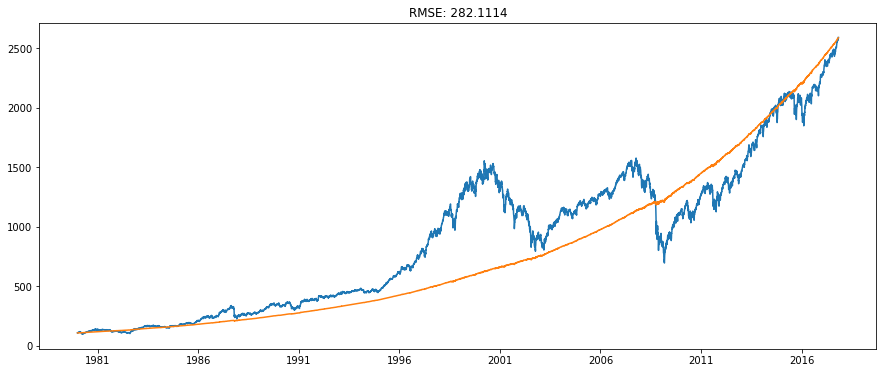

In [65]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(TimeSeries_data)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-TimeSeries_data)**2)/len(TimeSeries_data)))

In [ ]:
#Finally we have a forecast at the original scale. Not a very good forecast